In [1]:
# 2019.01.15
# Python v3.7.2 (Jupyter Notebook)
#
# 1. Input画像ファイル読み込み (パスをプログラムにべた書き) 
# 2. Input画像のハッシュ値算出
# 3. 他のプロジェクトIDのフォルダに入っている画像ファイルまとめて読み込み
# 4. 他の画像ファイルのハッシュ値算出
# 5. Input画像のハッシュ値と他の画像のハッシュ値の差分のリスト作成
# 6. 差分のリストを降順でソート
# 7. 上位5位(任意)をコンソールに表示
#
# TODO:
# - jpg対応?
# - 高速化、精度向上
#     - 別のハッシュ値算出アルゴリズム試してみる?
#     - ファイル探索処理工夫できないか確認
#     - サイズの影響が強いかどうか調べる
# - まったく同じ画像を除外などする工夫
# - GUI化
# - Input画像とOutput画像のサイズとかの情報取得する
# - Top5だけじゃなくてずらっと出せるように
# - Hash値は保存しておく
print("aaa")

from PIL import Image, ImageFile
import numpy as np
import imagehash
import os
from glob import glob
import re
import pprint
from collections import OrderedDict
from IPython.display import display_png
import time
import ipywidgets as widgets
from tkinter.filedialog import askopenfilename
# import Tkinter as tk
# from PIL import Image, ImageTk

aaa


In [9]:
# ---------------------------------
# Configrations and grobal variables
# ---------------------------------
# 表示する類似画像の個数
showImgNum = 5
# サイズの大きな画像をスキップしない
ImageFile.LOAD_TRUNCATED_IMAGES = True
selectedInputFile = "../scratch/splites/project1/741043/0.png"




def SetSelectButtonWdg():
    selectButtonWdg = widgets.Button(
        description = 'Click me',
        disabled = False,
        button_style = '', # 'success', 'info', 'warning', 'danger' or ''
        tooltip = 'Click me',
        icon = 'check'
    )
    # selectedInputImageWdg = 
    selectButtonWdg.on_click(OnSelectButtonClicked)
    
#     # Display
#     display(selectButtonWdg)
    
    return selectButtonWdg
    
    

def SetInputImgWdg(_selectedInputFile):
    inputImageWdg = widgets.Image(
        value = open(_selectedInputFile, "rb").read(),
        format = 'png'
    )
    return inputImageWdg


def OnSelectButtonClicked(b):
    fileType = [("inputImage", ".png")]
    initDir = "../scratch/splites/project1"
    selectedPath = askopenfilename(filetypes = fileType, initialdir = initDir)
#     print("Selected: " + str(selectedPath))

    selectedInputFile = "../" + re.sub(os.getcwd().strip("SimilarImageSearch"), "", selectedPath)
    print("Selected : " + selectedInputFile)
    
#     display(SetInputImgWdg(selectedInputFile))
    SetPath(selectedInputFile)

    
    




# ---------------------------------
# 
# ---------------------------------
def SetPath(_selectedInputFile):

    # Load an input image from  and Calculate the hash value
    # ---------------------------------
    # inputImg = "../scratch/splites/project1/3238181/6.png"
    inputImg = str(_selectedInputFile)
    inputHash = imagehash.phash(Image.open(inputImg))
#     print("Current Directory : " + os.getcwd())
#     print("Input Image : " + inputImg + "\nHash Value of Input Image >>> [" + str(inputHash) + "]\n")
#     display_png(Image.open(inputImg))
    
    # Calculate hash values of other images and difference values
    # ---------------------------------
    # input画像のパスから、input画像が所属するProjectIDの文字列、他のProjectIDフォルダが所属するプロジェクトフォルダのパスを取得
    # 正規表現メモ: 任意の1桁以上の数値\d{1,}
    path_inputPrjID = re.sub("\d{1,}.png", "", inputImg).strip("/") # "../scratch/splites/project1/262284
    # 正規表現メモ: 任意の英数字以外[\W]や英数字[\w]の0回以上の繰り返し*と記号/にマッチする部分を取り除く
    prjID = re.sub("[\W\w]*/", "", path_inputPrjID) # "262284"
    path_prj = path_inputPrjID.strip(prjID) # "../scratch/splites/project1/" 便宜上最後に"/"入れたままなので注意
    print("Project Path : " + path_prj + "\nProject ID : " + prjID + "\n")

    # すべての画像のパス取得
    pathList = glob(path_prj + "*/*.png") # 1つめの*はProjectIDをワイルドカードで指定(プロジェクトIDのフォルダごとに回すよりよさそう)
    # input画像が所属するProjectIDはハッシュ値算出から取り除く
    pathList = [path for path in pathList if prjID not in path] # 内包表記 [繰り返しindex for 繰り返しindex in 検索元]と[if 特定の文字列 in 検索元]
    print("Searched Images (" + str(len(pathList)) + "　files) are ...")
    pprint.pprint(pathList[0:3]) # 0から(4-1)番目までを取得
    
    CalcHashDif(inputHash, pathList)


def CalcHashDif(_inputHash, _pathList):
    # input画像以外のすべての画像のハッシュ値を算出
    hashList = [imagehash.phash(Image.open(img)) for img in _pathList]
    # difに2つの画像のハッシュ値の差分を入れる
    difList = [abs(_inputHash - h) for h in hashList] # intのlistで帰る
    # print(hashList[0])
    # print(difList)
    # print(len(difList))

    # Create dictionary from other image paths list and difference values list
    # Keyがpath、Valueがdifで順序を保った辞書を作る
    dic = OrderedDict((_pathList[i], difList[i]) for i in range(len(_pathList)))
    # print(k, v) for k, v in dic.items() # 辞書型の確認はこの方法のみ
    
    ShowTopSimilarImages(dic)
    

# ---------------------------------
# Show similar images
# ---------------------------------
def ShowTopSimilarImages(_dic):
    # Value(difList(ハッシュ値差分)の値)で降順でソート
    # lambdaは無名関数の定義で用いる決まり文句. "x[1]を返す無名の関数をkeyパラメータに入れる"的な意味らしい
    # https://qiita.com/n10432/items/e0315979286ea9121d57
    sortedDic = sorted(_dic.items(), key = lambda x:x[1]) # tupleのlistで帰ってくる
    print("Similar images are ...")
    pprint.pprint(sortedDic[0:3])
    
    print("Output : ")
    # key(パス)、0列目を取りだすのでsortedDic[i][0]の[0]
    [display_png(Image.open(sortedDic[i][0])) for i in range(showImgNum)]

    
    
    

    
def mainLoop():
    display(SetSelectButtonWdg())
    
    

    
# mainLoop()

Button(description='Click me', icon='check', style=ButtonStyle(), tooltip='Click me')

Selected : ../scratch/splites/project1/26228495/6.png
Project Path : ../scratch/splites/project1/
Project ID : 26228495

Searched Images (21　files) are ...
['../scratch/splites/project1/1047729/0.png',
 '../scratch/splites/project1/1047729/4.png',
 '../scratch/splites/project1/1047729/5.png']
Similar images are ...
[('../scratch/splites/project1/1047729/7.png', 20),
 ('../scratch/splites/project1/1173880/2.png', 26),
 ('../scratch/splites/project1/1173880/7.png', 26)]
Output : 


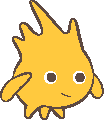

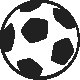

In [11]:
display(SetSelectButtonWdg())

In [12]:
display(SetInputImgWdg(selectedInputFile))

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xe0\x00\x00\x01h\x08\x06\x00\x00\x00\x8f7( \x00\…